# Programming Project #1: Hybrid Images

## CS445: Computational Photography - Fall 2019

### Part I: Hybrid Images

In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import signal

import utils

In [2]:
%matplotlib notebook

In [40]:
im1_file = './image/cat.png'
im2_file = './image/bird.jpg'

im1 = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)

<IPython.core.display.Javascript object>


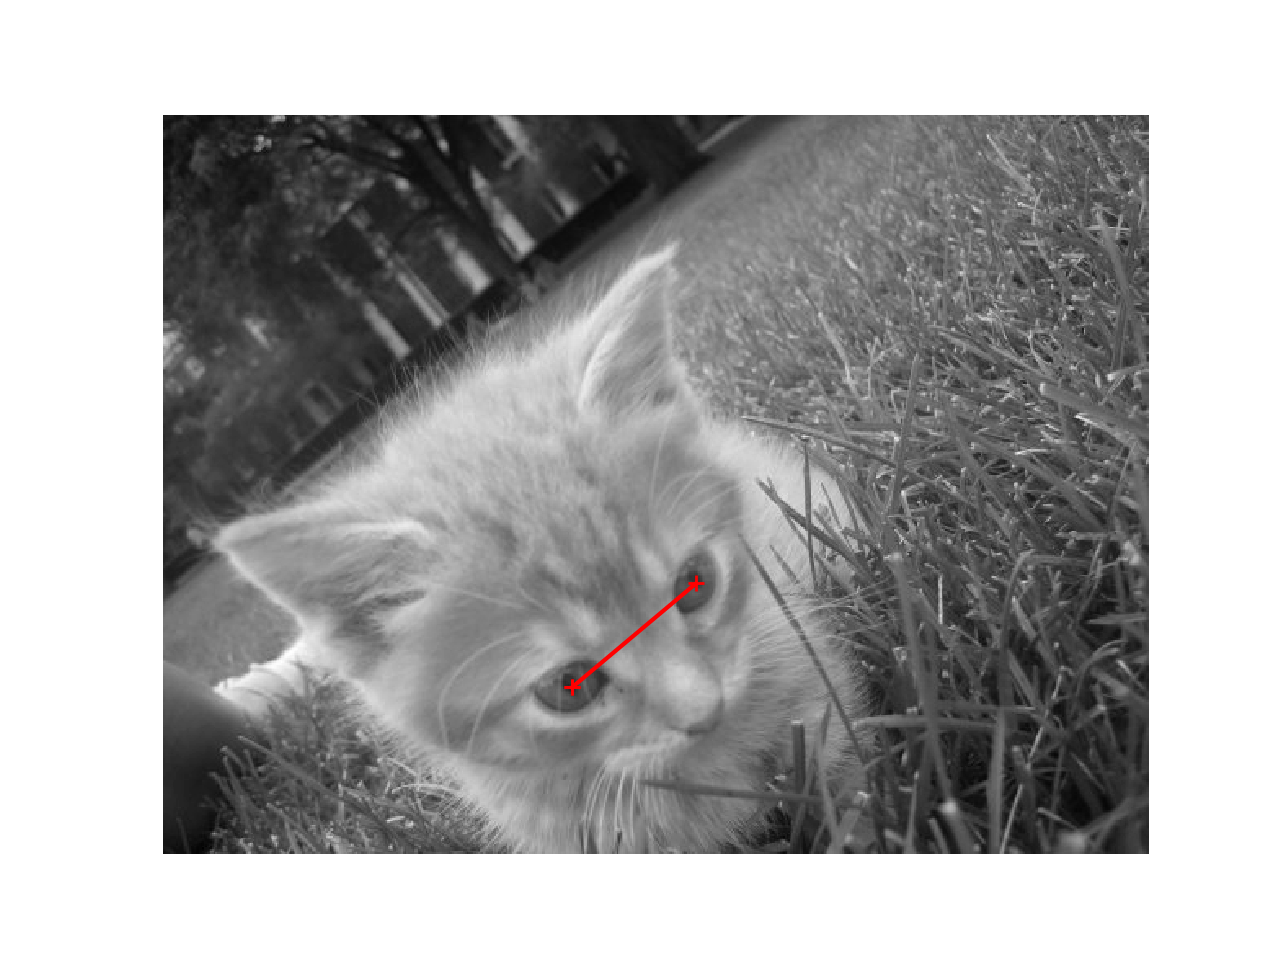

In [41]:
pts_im1 = utils.prompt_eye_selection(im1)

<IPython.core.display.Javascript object>


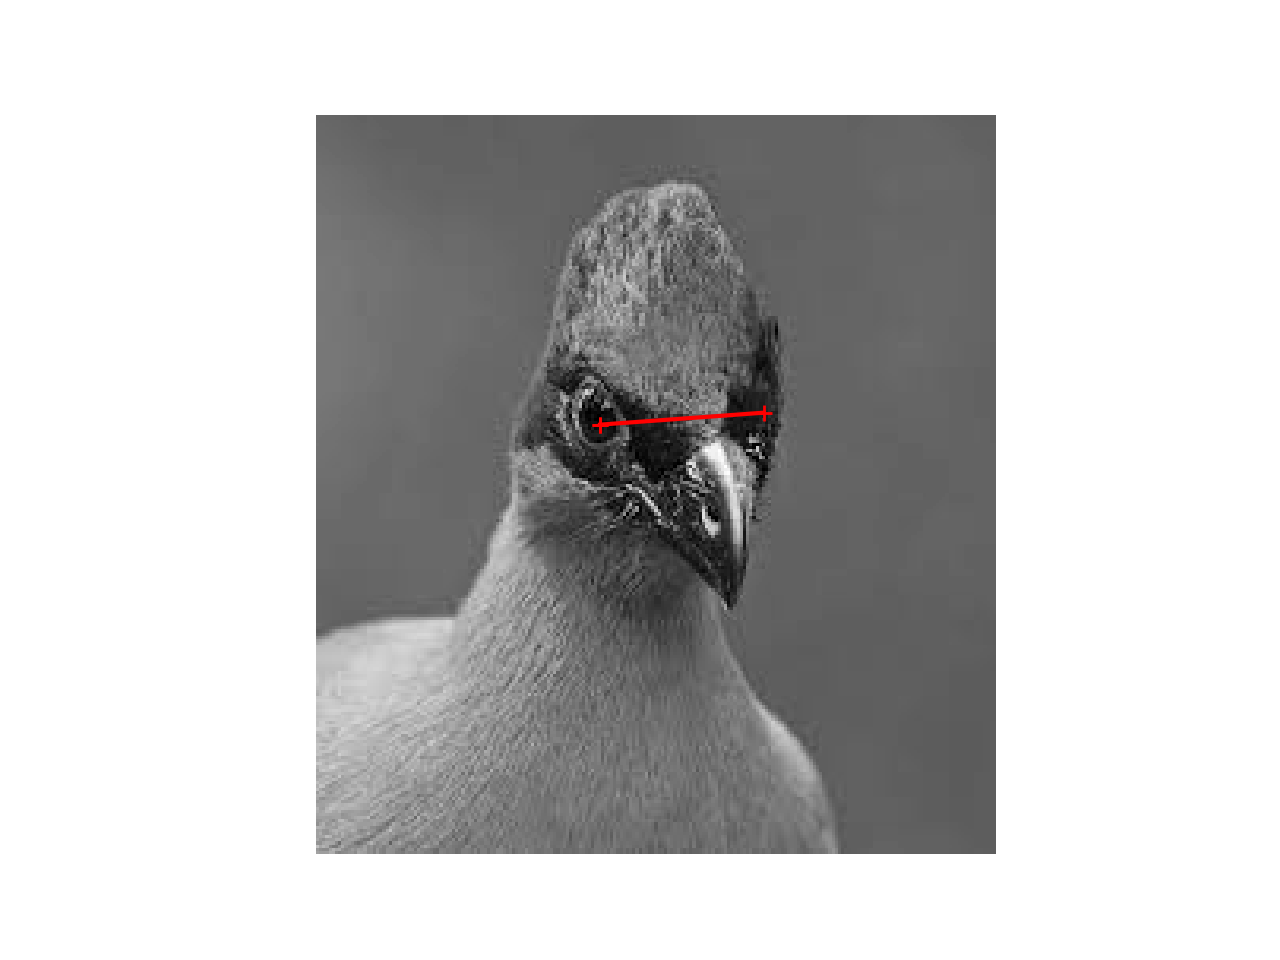

In [42]:
pts_im2 = utils.prompt_eye_selection(im2)

In [43]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

In [44]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

<IPython.core.display.Javascript object>


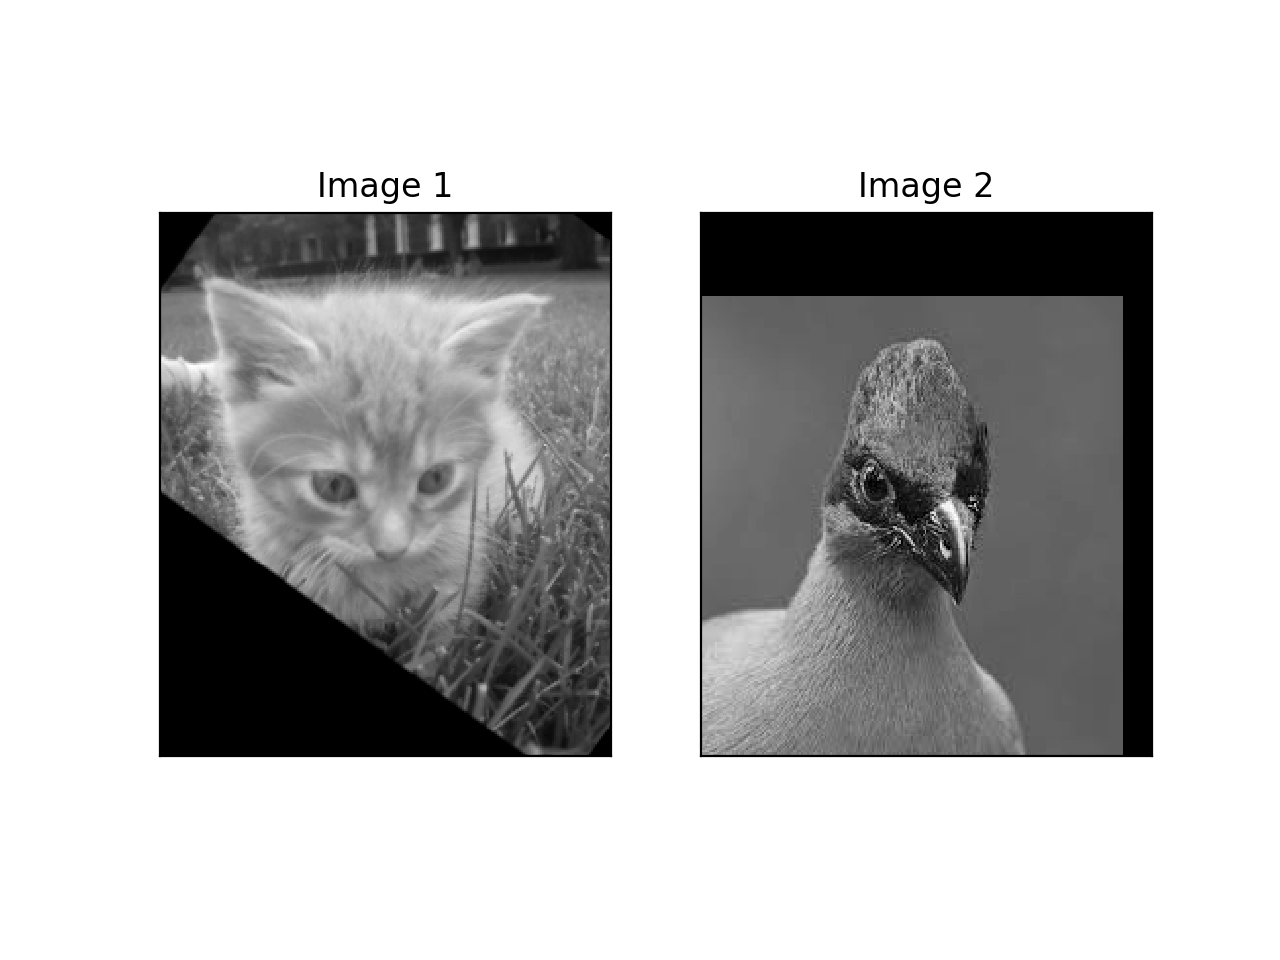

In [45]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [90]:
def filter_image(im, fil):
    '''
    im: H x W floating point numpy ndarray representing image in grayscale
    fil: M x M floating point numpy ndarray representing 2D filter
    '''
    H, W = im.shape
    hs = fil.shape[0] // 2 # half of filter size
    fftsize = max(1024 , H+hs, W+hs)        # should be order of 2 (for speed) and include padding
    im_fft = np.fft.fft2(im, (fftsize, fftsize))   # 1) fft im with padding
    fil_fft = np.fft.fft2(fil, (fftsize, fftsize)) # 2) fft fil, pad to same size as image
    im_fil_fft = im_fft * fil_fft;                 # 3) multiply fft images
    im_fil = np.fft.ifft2(im_fil_fft)              # 4) inverse fft2
    im_fil = im_fil[hs:hs + H, hs:hs + W]          # 5) remove padding
    im_fil = np.real(im_fil)                       # 6) extract out real part
    return im_fil

In [46]:
def display_frequency_image(frequency_image):
    '''
    frequency_image: H x W floating point numpy ndarray representing image after FFT
                     in grayscale
    '''
    shifted_image = np.fft.fftshift(frequency_image)
    amplitude_image = np.abs(shifted_image)
    log_amplitude_image = np.log(amplitude_image)
    fig = plt.figure()
    plt.imshow(log_amplitude_image) #cmap='gray')
    plt.colorbar()
    plt.show()

In [47]:
def hybridImage(im1, im2, cutoff_low, cutoff_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        cutoff_low: standard deviation for the low-pass filter
        cutoff_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''    
    # For a low-pass filter, Oliva et al. suggest using a standard 2D Gaussian filter.

    # For a high-pass filter, use the impulse filter minus the Gaussian filter, 
    # which can be computed by subtracting the Gaussian-filtered image from the original.
    '''
    high_Gaussian_filter = utils.gaussian_kernel(cutoff_high, cutoff_high*5)
    signal_filter = signal.unit_impulse(high_Gaussian_filter)
    high_filter = signal_filter - high_Gaussian_filter
    '''
    Gaussian_filter1 = utils.gaussian_kernel(cutoff_low, cutoff_low*4)
    display_frequency_image(Gaussian_filter1)
    plt.axis('off')
    plt.savefig('./image/FFT_LOW')     

    # Gaussian_filter2 = utils.gaussian_kernel(cutoff_high, cutoff_high*4)
    # filter_impulse = signal.unit_impulse(Gaussian_filter2.shape, 'mid')
    # Gaussian_filter22 = filter_impulse - Gaussian_filter2
    # display_frequency_image(Gaussian_filter22)
    # plt.axis('off')
    # plt.savefig('./image/FFT_HIGH')

    Gaussian_filter2 = utils.gaussian_kernel(cutoff_high, cutoff_high*4)
    plt.figure()
    plt.imshow(Gaussian_filter2)
    plt.axis('off')
    plt.savefig('./image/FFT_HIGH')

    im1_lowpass = cv2.filter2D(im1,-1,Gaussian_filter1) #filter_image(im1,Gaussian_filter1)
    im2_highpass = im2 - cv2.filter2D(im2,-1,Gaussian_filter2) #filter_image(im2,Gaussian_filter2)
    
    plt.figure()
    plt.imshow(im1_lowpass, cmap='gray')
    plt.axis('off')
    plt.savefig('./image/dog_filter_low.jpg')
    
    plt.figure()
    plt.imshow(im2_highpass, cmap='gray')
    plt.axis('off')
    plt.savefig('./image/me_filter_high.jpg')
    result = (im1_lowpass + im2_highpass) / 2
    return result

In [48]:
# low_Gaussian_filter = utils.gaussian_kernel(50, 20)
# display_frequency_image(low_Gaussian_filter)
# plt.figure()
# plt.imshow(low_Gaussian_filter)

<IPython.core.display.Javascript object>


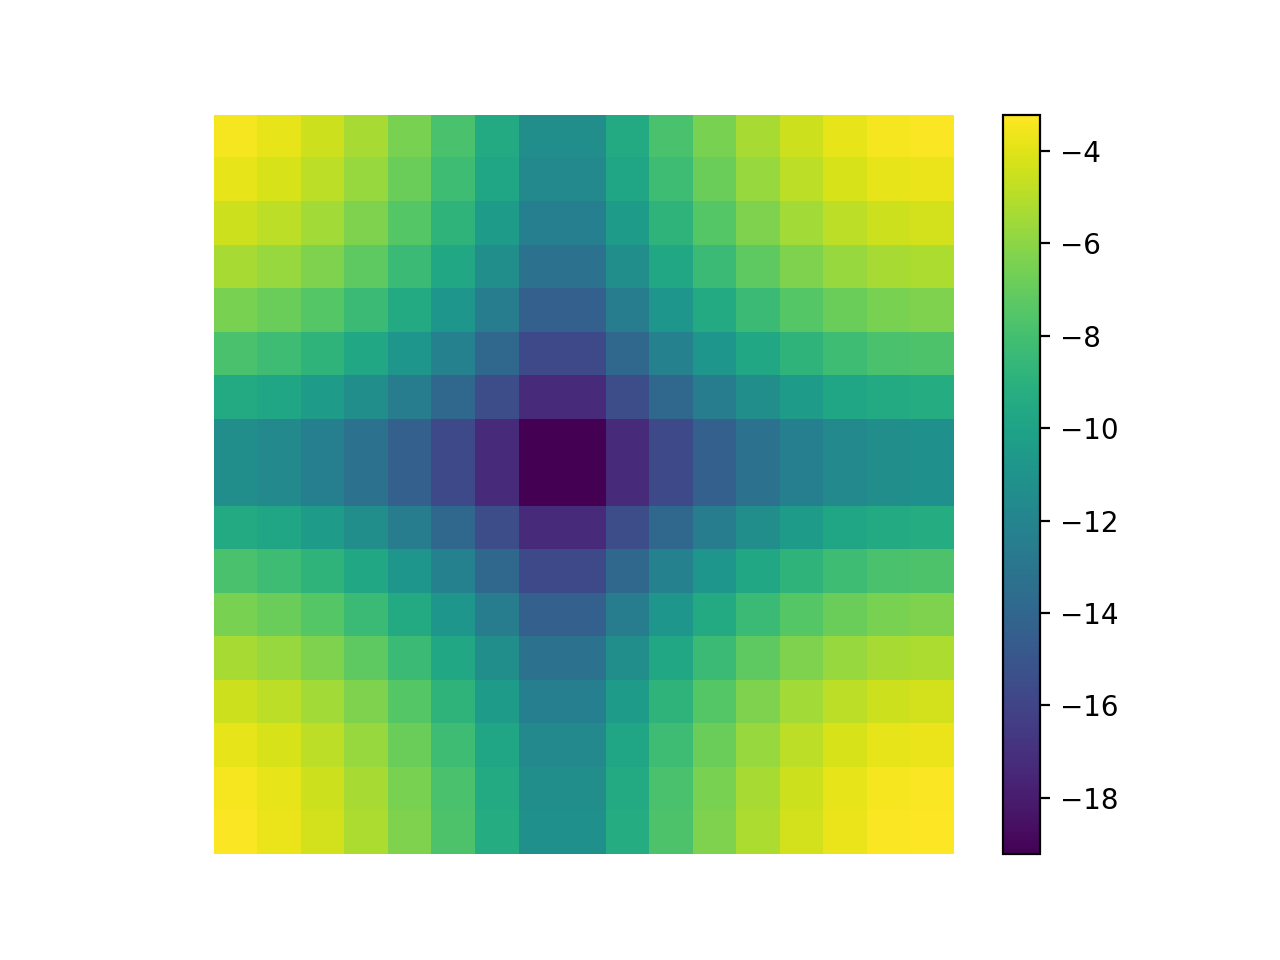

<IPython.core.display.Javascript object>


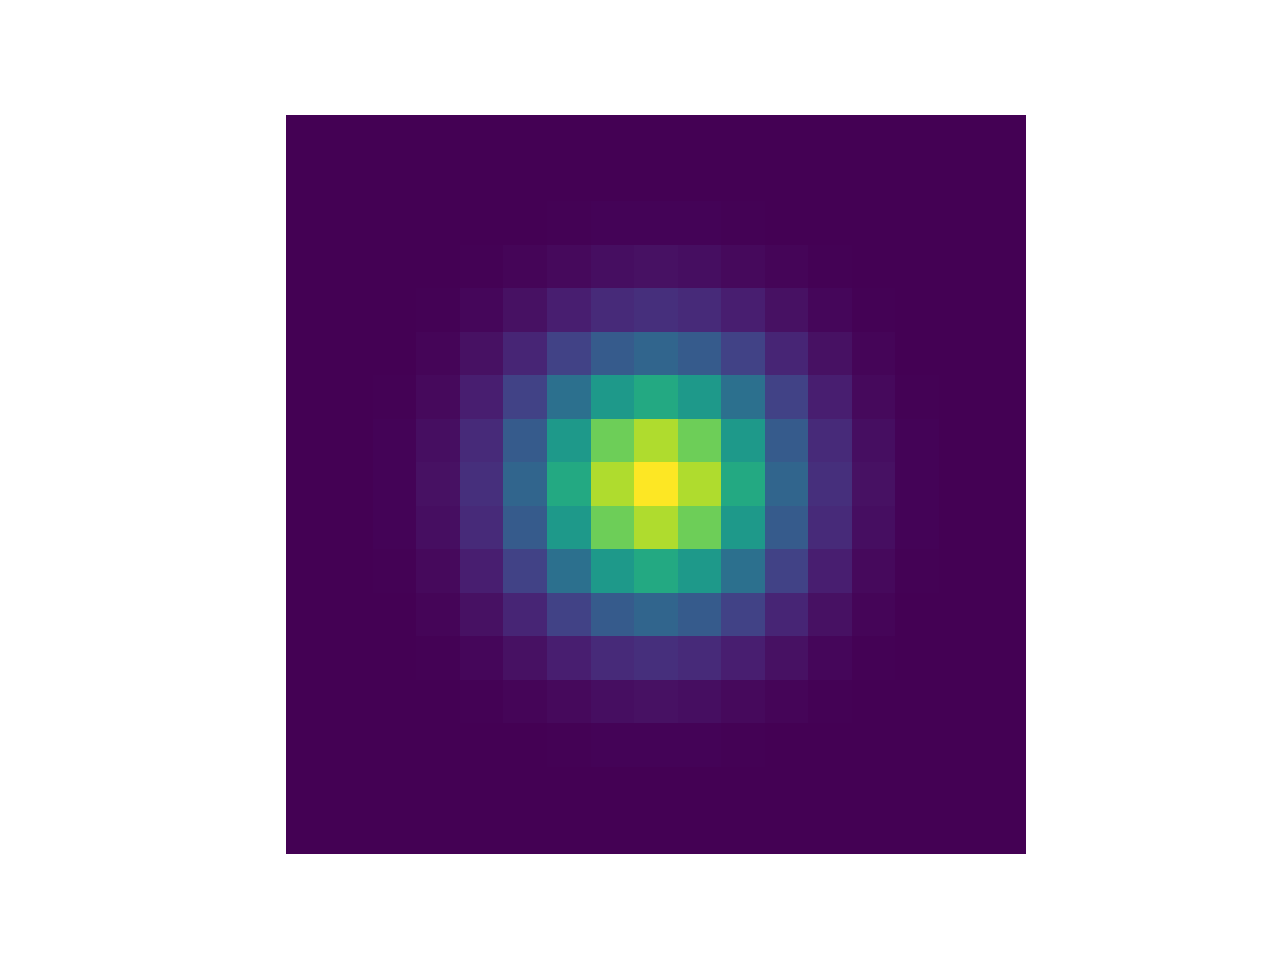

<IPython.core.display.Javascript object>


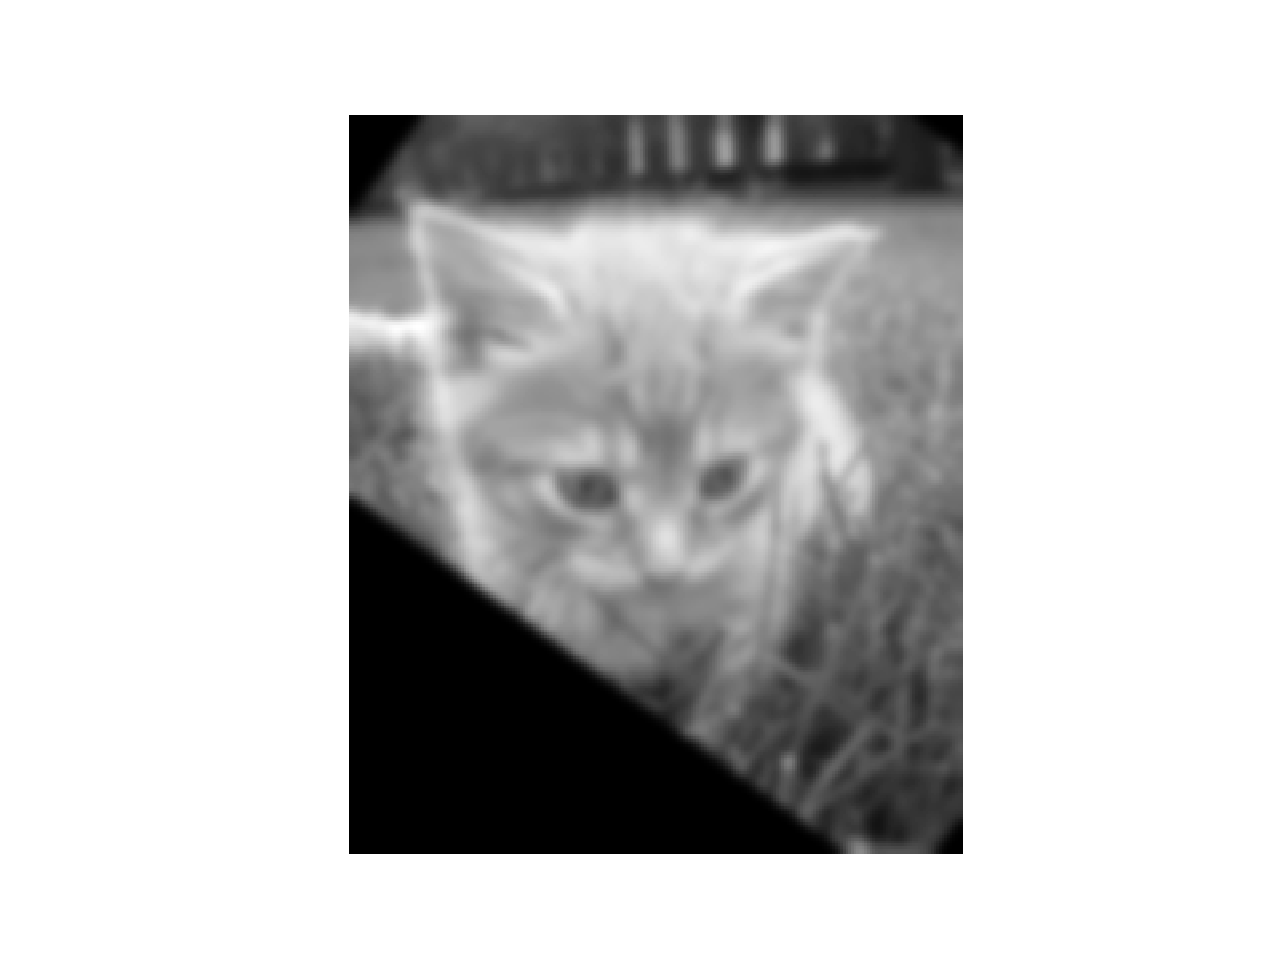

<IPython.core.display.Javascript object>


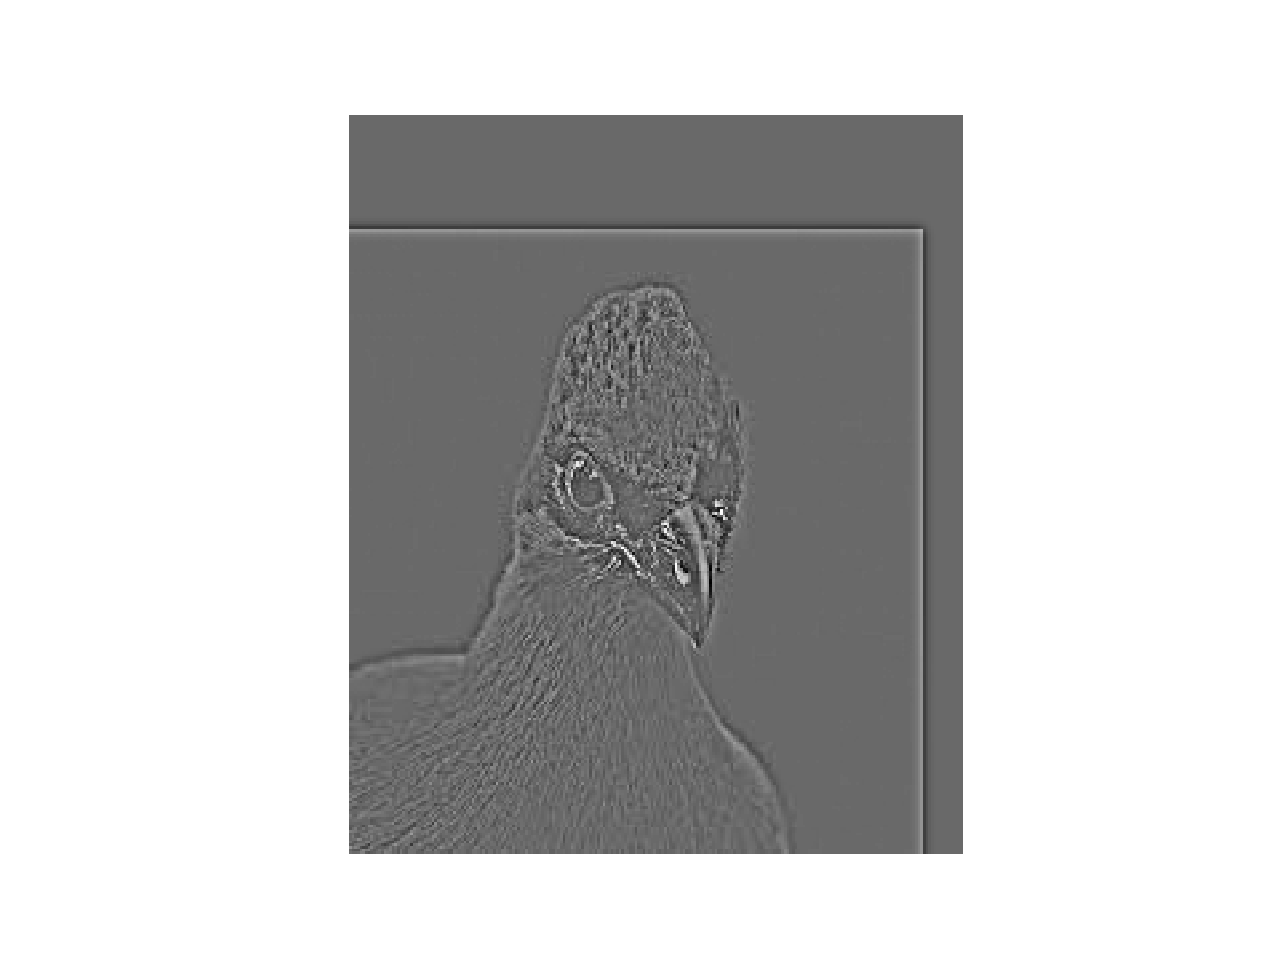

In [72]:
arbitrary_value = 20  # you should choose meaningful values; you might want to set to a fraction of image size
cutoff_low = 2   # the larger number is, the less high frequency, low frequency is more obvious
cutoff_high = 2   # the smaller number is, the less low frequency, high frequency is more obvious
im_hybrid = hybridImage(im1, im2, cutoff_low, cutoff_high)

<IPython.core.display.Javascript object>


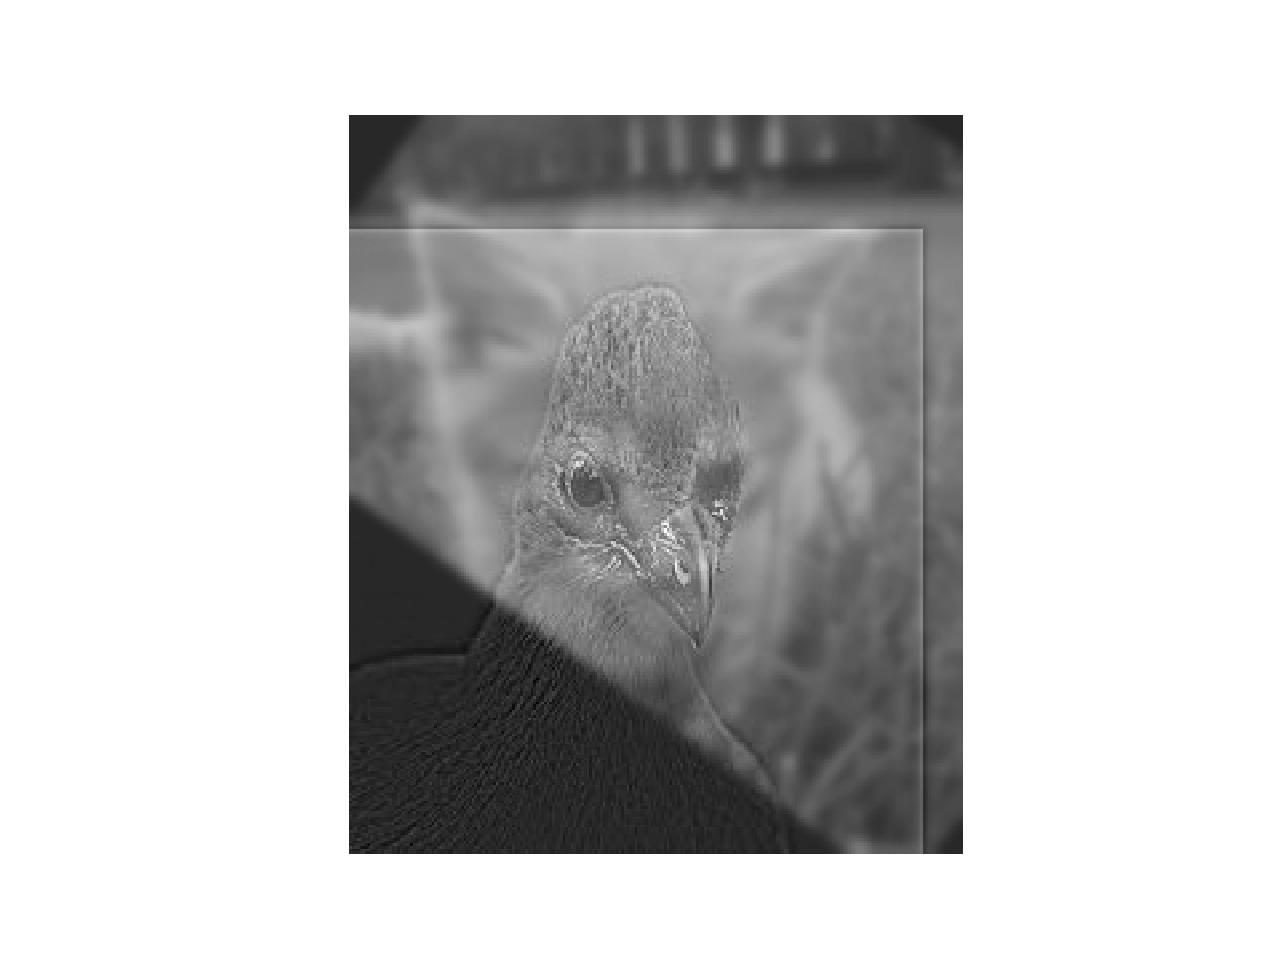

In [73]:
plt.figure()
plt.imshow(im_hybrid, cmap="gray")
plt.axis('off')
plt.savefig('./image/hybrid.jpg')

<IPython.core.display.Javascript object>


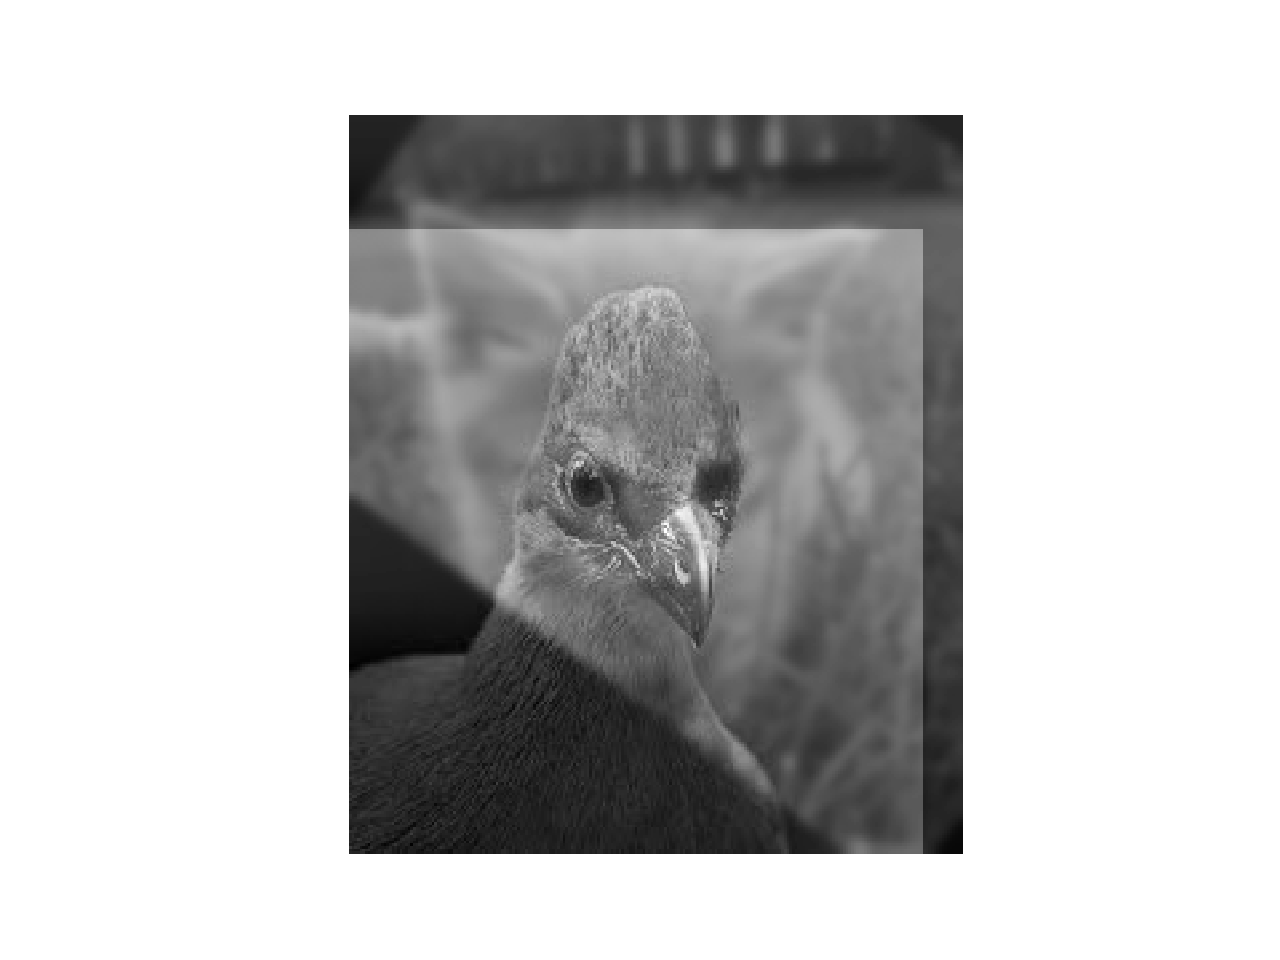

In [71]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }/

cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

In [121]:
# histogram equalization
def histogram_equalization(im, alpha):
    # just following the algorithm on the slide
    # Compute cumulative histogram
    # suppose all the pixel values are in [0, 255]
    H = np.zeros(256)
    C = np.zeros(256)
    new_H = np.zeros(256)
    new_C = np.zeros(256)
    Fi = np.copy(im)
    if len(Fi.shape) == 3:
        for color_idx in range(im.shape[-1]):
            for i in range(im.shape[0]):
                for j in range(im.shape[1]):
                    H[int(im[i,j,color_idx])] += 1
                    C[int(im[i,j,color_idx])] = H[int(im[i,j,color_idx])] + C[int(im[i,j,color_idx]) - 1]
            
            for i in range(im.shape[0]):
                for j in range(im.shape[1]):
                    Fi[i,j,color_idx] = alpha * C[int(im[i,j,color_idx])]/im.size *255 + (1- alpha) * int(im[i,j,color_idx])
        for color_idx in range(im.shape[-1]):
            for i in range(im.shape[0]):
                for j in range(im.shape[1]):
                    new_H[int(Fi[i,j,color_idx])] += 1
                    new_C[int(Fi[i,j,color_idx])] = new_H[int(Fi[i,j,color_idx])] + new_C[int(Fi[i,j,color_idx]) - 1]
    else:
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                H[int(im[i,j])] += 1
                C[int(im[i,j])] = H[int(im[i,j])] + C[int(im[i,j]) - 1]
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                Fi[i,j] = alpha * C[int(im[i,j])]/im.size *255 + (1- alpha) * int(im[i,j])    
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                new_H[int(Fi[i,j])] += 1
                new_C[int(Fi[i,j])] = new_H[int(Fi[i,j])] +  new_C[int(Fi[i,j]) - 1]
       
    return Fi, h, c, h_new, c_new
        


In [150]:
im3_file = './image/my_dog.jpg'
im3 = cv2.imread(im3_file, cv2.IMREAD_GRAYSCALE)

alpha = 0.5 # if alpha = 0, then the output is the original image
output_im3, h, c, h_new, c_new = histogram_equalization(im3, alpha)

<IPython.core.display.Javascript object>


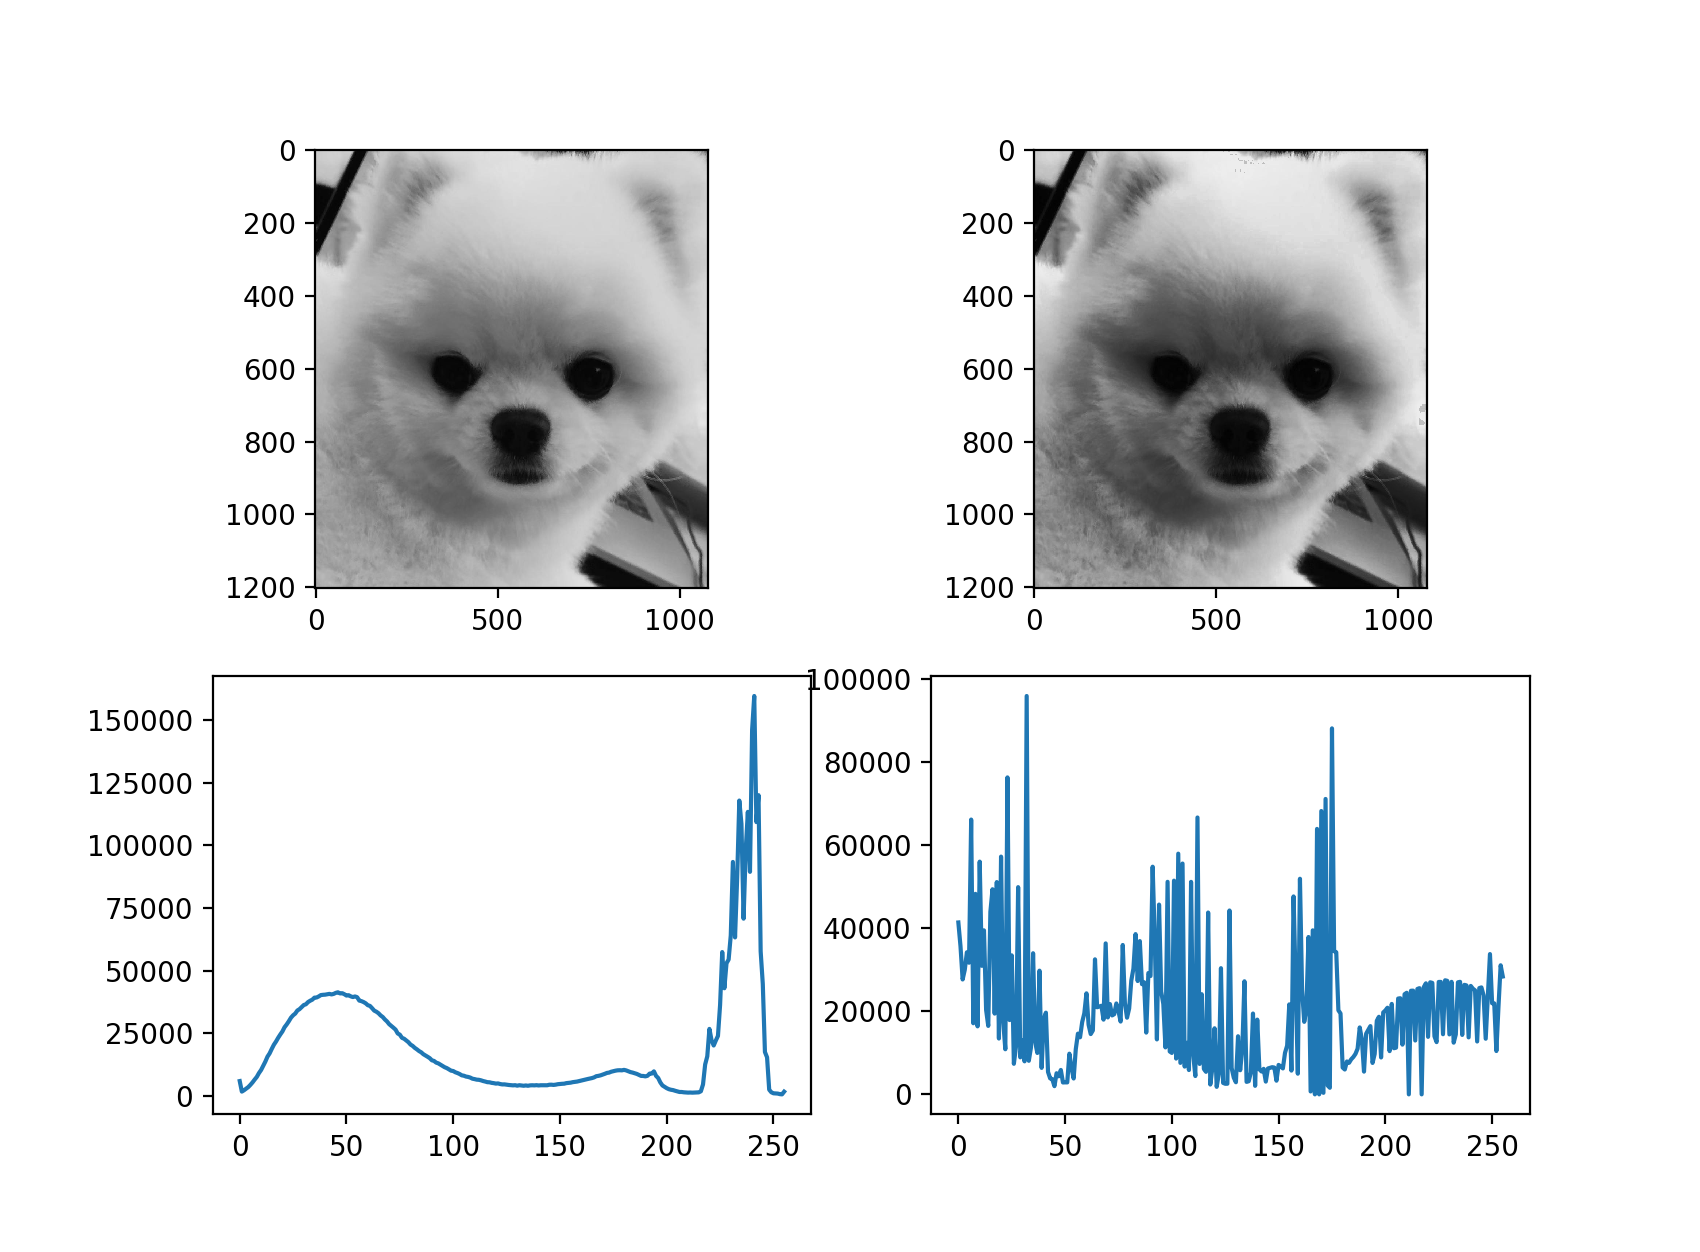

In [183]:
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
axes[0,1].imshow(cv2.cvtColor(output_im3, cv2.COLOR_BGR2RGB))
axes[1,0].plot(np.arange(len(h_new)),h)
axes[1,1].plot(np.arange(len(h_new)),h_new)

#### Color enhancement

In [230]:
# Convert the images to HSV color space and divide into hue, saturation, and value channels.
# (hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV) in OpencCv)
# we use the function upper(x/(1+x)*256) to mapping all the positive values into the range [0,255]
from matplotlib.colors import hsv_to_rgb
def color_enhancement(im, factor_h, factor_s, factor_v):
    hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)

    # pixel = [x/(1+x)*256] -> x = pixel/(256-pixel)
    arr = hsv/(256-hsv)
    arr[:,:,0] = arr[:,:,0]*factor_h
    arr[:,:,1] = arr[:,:,1]*factor_s
    arr[:,:,2] = arr[:,:,2]*factor_v
    
    arr_one = np.ones(hsv.shape)
    new_hsv = arr/(arr + arr_one) * 256
    
    output_im = hsv_to_rgb(new_hsv/256)
    return output_im

<IPython.core.display.Javascript object>


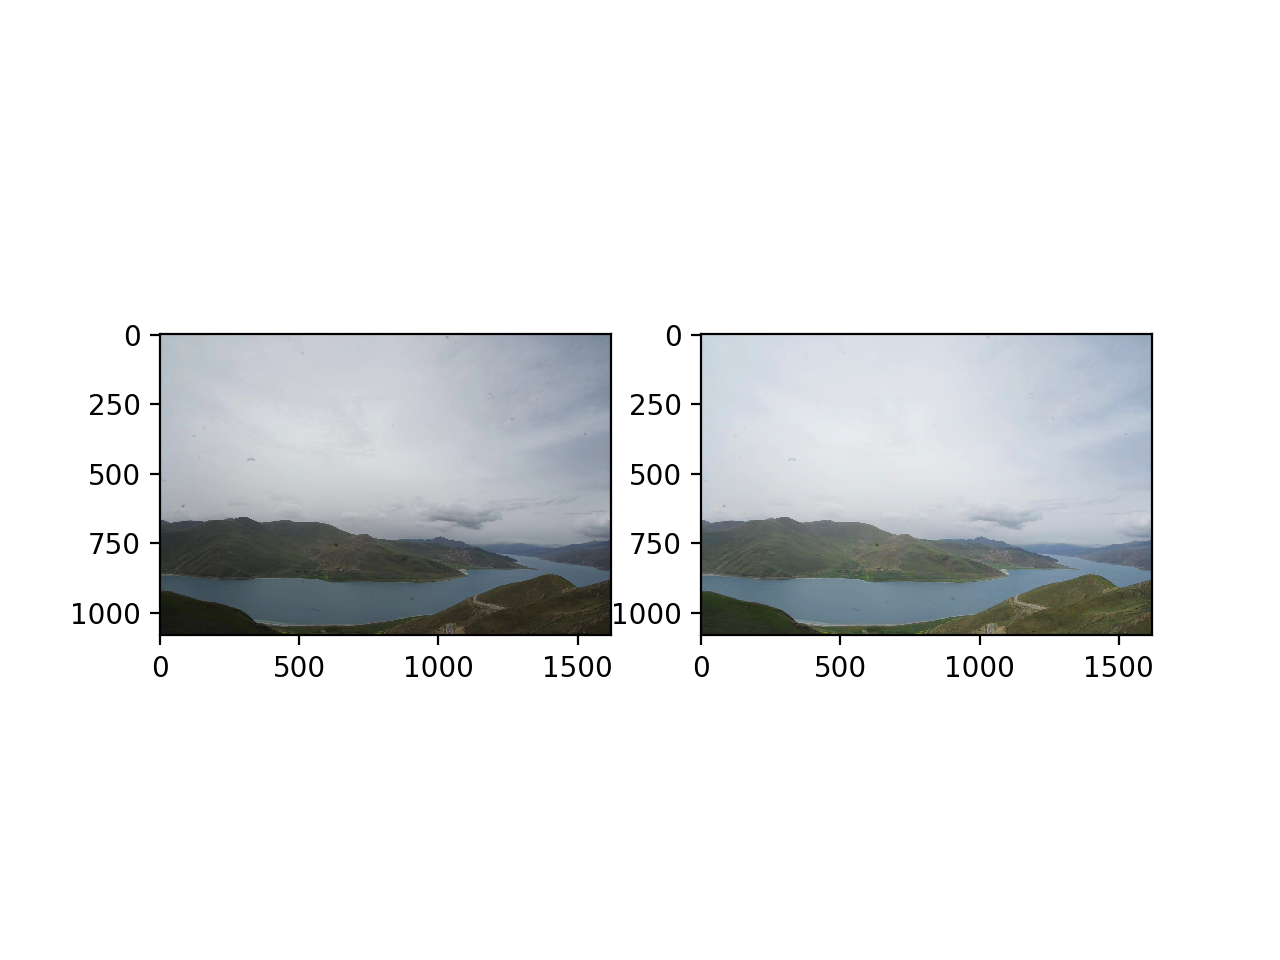

In [231]:
# let's have a look at the result
im4_file = './image/river1.jpg'
im4 = cv2.imread(im4_file)
output_im4 = color_enhancement(im4,2,1,2)


fig, axes = plt.subplots(1,2)
axes[0].imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))
axes[1].imshow(output_im4)

#### Color shift